In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Loading the dataset
file_path = r"D:\indian_traffic\echallan_daily_data.csv"
traffic_df = pd.read_csv(file_path)

In [9]:
traffic_df.head()

,date,totalChallan,disposedChallan,pendingChallan,pendingAmount,disposedAmount,totalAmount,pendingCourt,disposedCourt,totalCourt
0,2015-01-01,120,29,91,588600,116860,705460,1,0,1
1,2015-01-02,162,39,123,663350,281425,944775,1,1,2
2,2015-01-03,122,34,88,596900,286950,883850,4,1,5
3,2015-01-04,116,27,89,967350,301600,1268950,3,2,5
4,2015-01-05,162,28,134,877654,103000,980654,2,0,2


In [11]:
# Preprocessing
traffic_df['date'] = pd.to_datetime(traffic_df['date'], errors='coerce')
traffic_df = traffic_df.dropna(subset=['date'])
traffic_df = traffic_df.sort_values(by='date')
traffic_df = traffic_df.reset_index(drop=True)

# Removing the incomplete final record if present any
traffic_df = traffic_df.iloc[:-1]

In [17]:
# Trend Indicator
traffic_df['weekly_trend'] = traffic_df['totalChallan'].rolling(window=7).mean()
traffic_df['monthly_trend'] = traffic_df['totalChallan'].rolling(window=30).mean()

In [23]:
# yearly performance metrics
yearly_summary = traffic_df.groupby(traffic_df['date'].dt.year).agg({
    'totalChallan':'sum',
    'disposedChallan':'sum',
    'disposedAmount':'sum'
}).rename(columns={
    'totalChallan':'Total',
    'disposedChallan':'Disposed',
    'disposedAmount':'Revenue'
})

yearly_summary['Disposal_Efficiency'] = yearly_summary['Disposed'] / yearly_summary['Total']
yearly_summary['YoY_Growth'] = yearly_summary['Total'].pct_change()


In [25]:
# monthly violation behavior
traffic_df['month'] = traffic_df['date'].dt.month
monthly_pattern = traffic_df.groupby('month')['totalChallan'].mean()

#weekday behavior study
traffic_df['weekday'] = traffic_df['date'].dt.day_name()
weekday_pattern = traffic_df.groupby('weekday').agg({
    'totalChallan':'mean',
    'disposedAmount':'mean'
})

In [27]:
# daily system efficiency
traffic_df['daily_efficiency'] = traffic_df['disposedChallan'] / traffic_df['totalChallan']
traffic_df['efficiency_smooth'] = traffic_df['daily_efficiency'].rolling(window=30).mean()

In [29]:
# finance resolution tracking
traffic_df['unpaid_ratio'] = traffic_df['pendingAmount'] / traffic_df['disposedAmount']

In [31]:
# load indicator
traffic_df['court_ratio'] = traffic_df['totalCourt'] / traffic_df['totalChallan']

In [33]:
# Correlation insights
correlation_matrix = traffic_df[[
    'totalChallan',
    'disposedAmount',
    'totalCourt',
    'disposedChallan'
]].corr()

In [35]:
# anamoly detection
traffic_df['rolling_avg'] = traffic_df['totalChallan'].rolling(window=365).mean()
traffic_df['rolling_std'] = traffic_df['totalChallan'].rolling(window=365).std()
traffic_df['z_score'] = (traffic_df['totalChallan'] - traffic_df['rolling_avg']) / traffic_df['rolling_std']
traffic_df['anomaly_flag'] = np.where(abs(traffic_df['z_score']) > 2.5, 1, 0)

In [37]:
# avg fine monitoring
traffic_df['avg_fine'] = traffic_df['disposedAmount'] / traffic_df['totalChallan']

In [41]:
# seasonal decomposition
decomposition = seasonal_decompose(
    traffic_df.set_index('date')['totalChallan'].dropna(),
    model='additive',
    period=365
)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [43]:
# yearly resolution
yearly_resolution = traffic_df.groupby(traffic_df['date'].dt.year).agg({
    'disposedChallan':'sum',
    'pendingChallan':'sum'
})

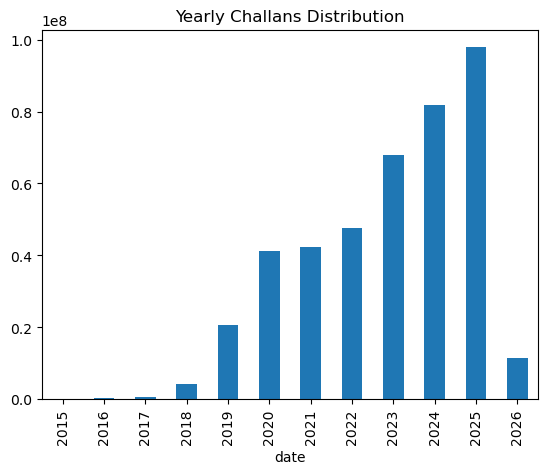

In [49]:
# yearly total challans 
yearly_totals = traffic_df.groupby(traffic_df['date'].dt.year)['totalChallan'].sum()
plt.figure()
yearly_totals.plot(kind='bar')
plt.title('Yearly Challans Distribution')
plt.show()

In [ ]:
#Shows how traffic enforcement intensity has changed over the years helping identify whether rule monitoring has strengthened or weakened.

#Highlights policy impact sudden increases may indicate stricter regulations or digital enforcement drives.

#Helps understand long-term compliance trends — rising challans may reflect increased violations or improved detection systems.

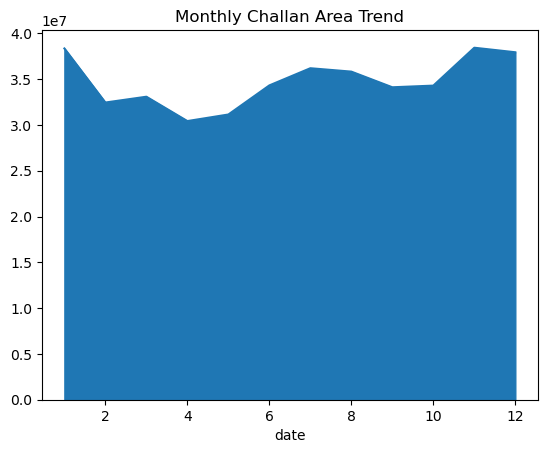

In [51]:
# monthly trend
monthly_totals = traffic_df.groupby(traffic_df['date'].dt.month)['totalChallan'].sum()
plt.figure()
monthly_totals.plot(kind='area')
plt.title('Monthly Challan Area Trend')
plt.show()

In [ ]:
#Reveals seasonal patterns in violations — certain months may show higher traffic offences due to festivals, holidays, or travel seasons.

#Helps identify periods of enforcement focus — spikes may indicate targeted drives by authorities.

#Shows how traffic behaviour fluctuates throughout the year rather than staying constant.

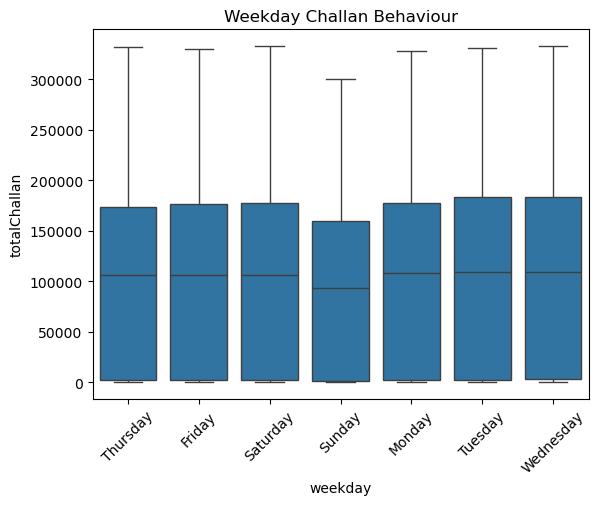

In [53]:
# weekday behavior
plt.figure()
sns.boxplot(x=traffic_df['weekday'], y=traffic_df['totalChallan'])
plt.title('Weekday Challan Behaviour')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Displays variation in violations across different days helping detect high-risk days like weekends.

#Shows consistency vs unpredictability wider boxes indicate unstable traffic behaviour.

#Helps understand whether violations are routine (workdays) or leisure-driven (weekends).

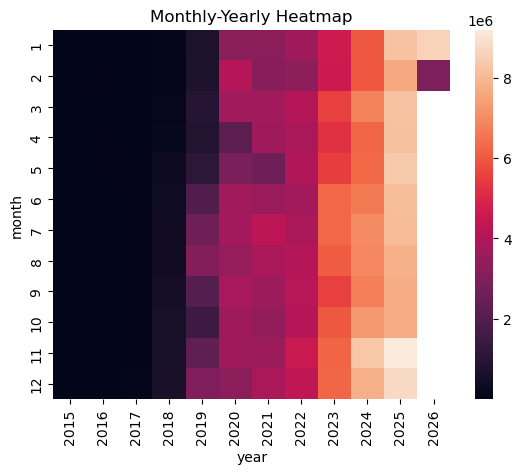

In [55]:
# month year
traffic_df['year'] = traffic_df['date'].dt.year
heatmap_data = traffic_df.pivot_table(values='totalChallan', index='month', columns='year', aggfunc='sum')
plt.figure()
sns.heatmap(heatmap_data)
plt.title('Monthly-Yearly Heatmap')
plt.show()

In [ ]:
#Provides a detailed view of enforcement intensity across both time dimensions month and year.

#Helps detect recurring seasonal peaks in specific years.

#Useful for spotting abnormal months where violations sharply increased or dropped

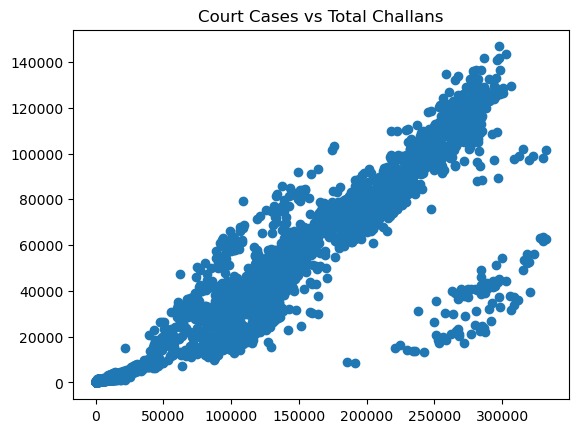

In [57]:
# court vs challan
plt.figure()
plt.scatter(traffic_df['totalChallan'], traffic_df['totalCourt'])
plt.title('Court Cases vs Total Challans')
plt.show()

In [ ]:
#Shows the relationship between total violations and legal escalations.

#Helps understand whether increased enforcement leads to higher judicial burden.

#Identifies whether violations are being resolved directly or pushed to court.

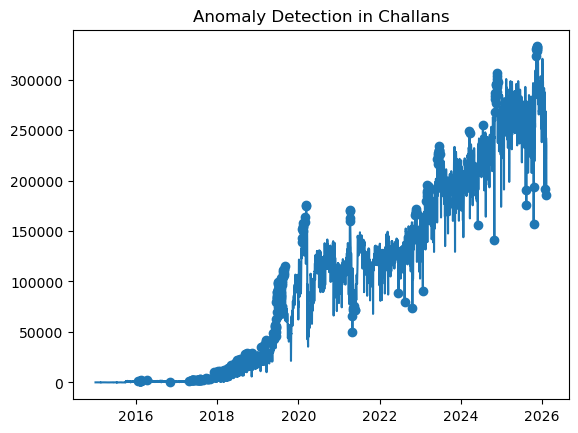

In [59]:
# anomaly highlight plot
plt.figure()
plt.plot(traffic_df['date'], traffic_df['totalChallan'])
plt.scatter(traffic_df[traffic_df['anomaly_flag']==1]['date'],
            traffic_df[traffic_df['anomaly_flag']==1]['totalChallan'])
plt.title('Anomaly Detection in Challans')
plt.show()

In [ ]:
#Highlights unusual spikes in traffic violations that deviate from normal trends.

#These anomalies may represent special enforcement drives, policy changes, or major events.

#Helps detect periods of sudden behavioural shifts in traffic compliance.

In [61]:
# Exporting the final data


output_path = r"D:\indian_traffic\processed_echallan_analysis.csv"

traffic_df.to_csv(output_path, index=False)

print("Processed dataset saved successfully")
print("Location:", output_path)

Processed dataset saved successfully
Location: D:\indian_traffic\processed_echallan_analysis.csv
